# Read an ISRed image mosaic from the butler and fit ghost spots

## Setup and imports

In [1]:
! eups list -s lsst_distrib

   g4213664e8e+b08e1c1b0b 	current w_2024_04 setup


In [2]:
# %matplotlib ipympl

# plotting
import pylab as plt
import numpy as np

# butler
from lsst.daf.butler import Butler

# isr and display
import lsst.afw.display as afwDisplay
from lsst.afw.image import Image

# camera stuff
import lsst.afw.math as afwMath
from lsst.afw.cameraGeom import utils as cgu
from lsst.obs.lsst import LsstCam

# Astropy nice plotting
from astropy.visualization import imshow_norm, MinMaxInterval, AsinhStretch, LinearStretch, \
                                  SqrtStretch,ContrastBiasStretch,ZScaleInterval, \
                                  AsymmetricPercentileInterval,ManualInterval



## Helpers

In [3]:
def displayExposure(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    afw_display.setImageColormap(cmap='gray')
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')
    return afw_display

def displayImage(image,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    #afw_display.scale('linear', min=-5, max=10)
    afw_display.setImageColormap(cmap='plasma')
    afw_display.mtv(image)
    plt.title(title)
    plt.gca().axis('off')
    return afw_display

def displayImageGhosts(image,title=None, frame_size=16):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(frame_size,frame_size))
    afw_display = afwDisplay.Display(1)
    #afw_display.scale('asinh', 'zscale')
    afw_display.scale('linear', min=0, max=20)
    afw_display.setImageColormap(cmap='plasma')
    afw_display.mtv(image)
    plt.title(title)
    #plt.gca().axis('off')
    return afw_display

def displayImageGhostsOnAxis(image,ax, title=None, frame_size=16):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(frame_size,frame_size))
    afw_display = afwDisplay.Display(1)
    #afw_display.scale('asinh', 'zscale')
    afw_display.scale('linear', min=0, max=20)
    afw_display.setImageColormap(cmap='plasma')
    afw_display.mtv(image)
    plt.title(title)
    #plt.gca().axis('off')
    return afw_display

def array_from_mosaic(mosaic):
    mar = mosaic.getArray()
    mma= np.ma.filled(np.ma.masked_values(mar,0.0000),np.nan)
    return mma

def show_hv_slices(imgarray, vpix, hpix, ccdname):
    plt.rcParams["figure.figsize"] = [12, 6]
    fig, ax = plt.subplots(1, 2)
    subax = imgarray[vpix]
    x = range(len(subax))
    ax[0].plot(x, subax)
    ax[0].set_title(f'Horizontal slice on {ccdname} at pixel {vpix}')
    subay = np.transpose(imgarray)[hpix]
    y = range(len(subay))
    ax[1].plot(y, subay)
    ax[1].set_title(f'Vertical slice on {ccdname} at pixel {hpix}')

def make_stamp(x_center, y_center, ds=100):
    """ Make a stamp image around a ghost position
    """
    from lsst.geom import Point2I, Box2I
    ghost_box = Box2I(minimum=Point2I(x=x_center-ds, y=y_center-ds), maximum=Point2I(x=x_center+ds, y=y_center+ds))
    ghost_stamp = imageF[ghost_box]   # same as no ImageOrigin argument
    return ghost_stamp
    

## Connect to the Butler repository

In [4]:
import lsst.daf.butler as daf_butler
repo = "/sdf/data/rubin/repo/ir2"
butler = daf_butler.Butler(repo)

In [5]:
collections = butler.registry.queryCollections(f"u/bregeon/eo_focal_plane_mosaic*",
                                               collectionTypes=daf_butler.CollectionType.CHAINED)
for item in collections[:5]:
    print(item)

u/bregeon/eo_focal_plane_mosaic_3023062500401_w_2024_12


In [6]:
myref=list(set(butler.registry.queryDatasets(datasetType='eoFpMosaic',
                                       instrument='LSSTCam',
                                       collections=collections)))

In [7]:
imageF = butler.get(myref[0])

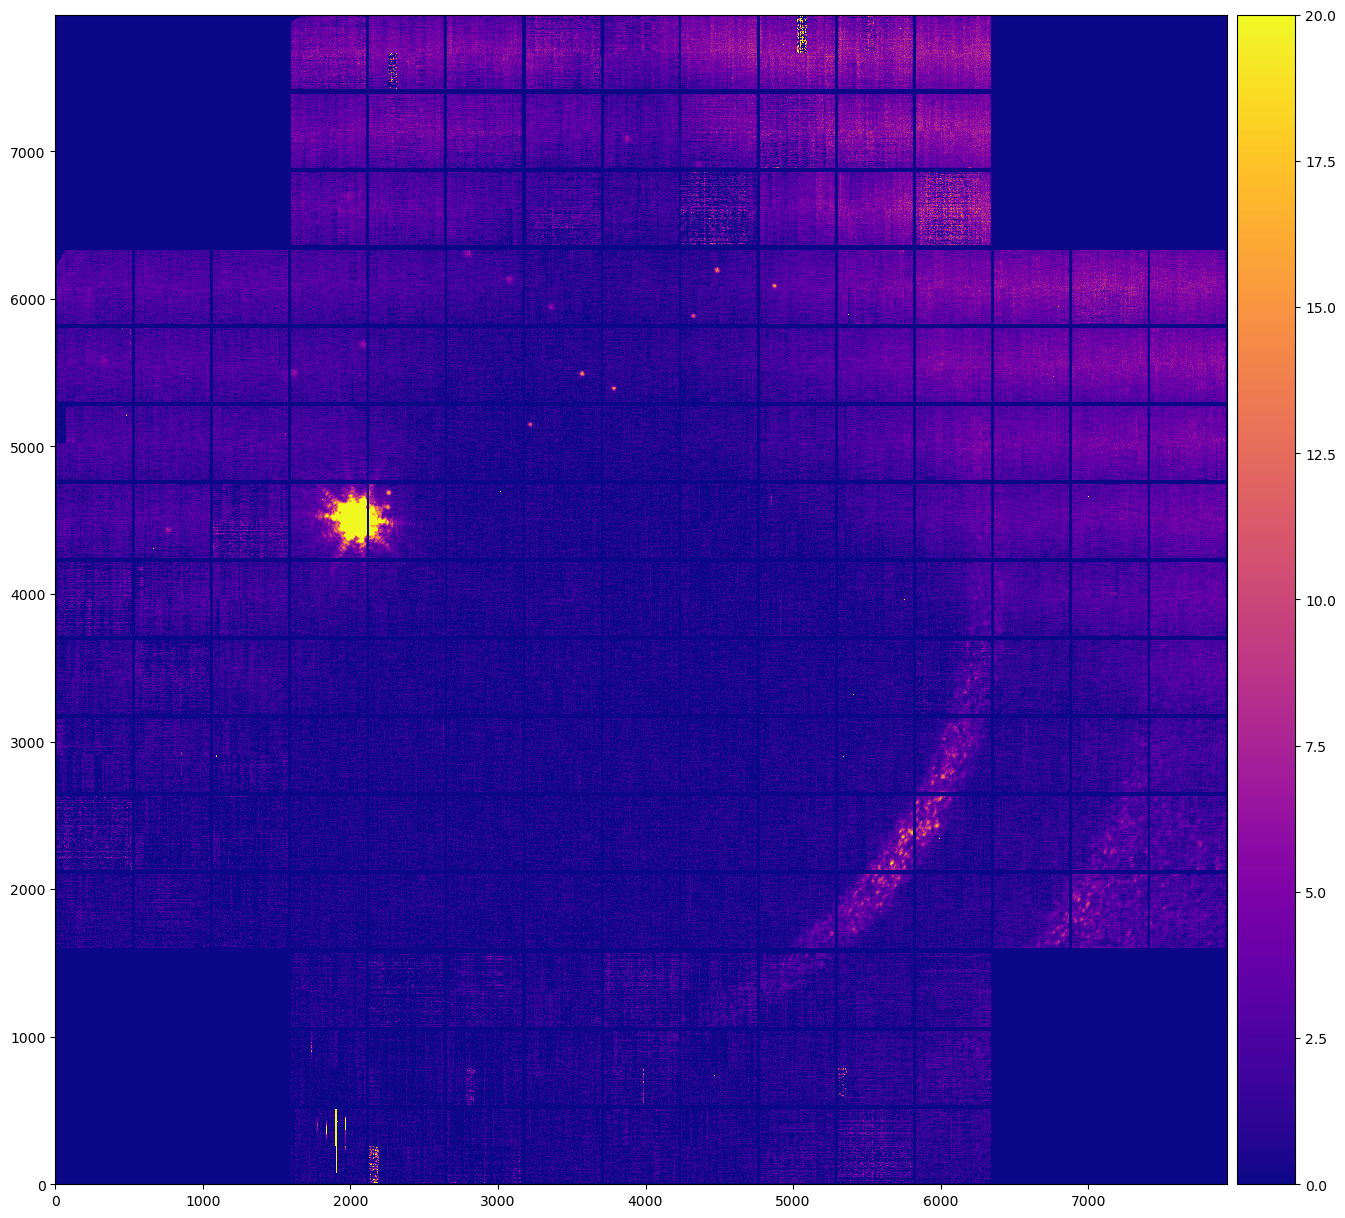

In [8]:
displayImageGhosts(imageF)
#plt.title(title)
#plt.gca().axis('off')
#afw_display.interact()
#afw_display.zoom(zoomfac=50, colc=750, rowc=4500)


In [9]:
from scipy import optimize

def gaussian(bkg, height, center_x, center_y, width):
    """Returns a gaussian function with the given parameters"""
    width = float(width)
    bkg = float(bkg)
    return lambda x,y: bkg + height*np.exp(
                -(((center_x-x)/width)**2+((center_y-y)/width)**2)/2)

def moments(data):
    """Returns (height, x, y, width)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    height = data.max()
    bkg = data.mean()
    return bkg, height, x, y, width

def fitgaussian(data):
    """Returns (height, x, y, width)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    print(params)
    return p

def ghost_fitter(ghost_stamp):
    """ Fit a 2D gaussian on a ghost stamp
    """
    # data - transpose for the fit
    stamp_array = np.transpose(ghost_stamp.getArray())
    # Fit centered in (100,100)
    params = fitgaussian(stamp_array)
    # verification
    # fit = gaussian(*params)
    # plt.matshow(cutout, cmap='plasma')
    # plt.contour(fit(*np.indices(cutout.shape)), cmap=plt.cm.copper)
    # Move Gaussian to focal plane coordinates
    rc_params = params.copy()
    rc_params[2] = params[2]+ghost_stamp.getX0()
    rc_params[3] = params[3]+ghost_stamp.getY0()
    rc_fit = gaussian(*rc_params)
    print(rc_params)
    return rc_params

def do_ghost(ghost_xy):    
    ghost_stamp = make_stamp(*ghost_xy)
    params = ghost_fitter(ghost_stamp)
    display_ghost_fit(ghost_stamp, params)


In [10]:
def display_ghost_fit(ghost_stamp, params):
    # plot ghosts stamp
    afwdisplay = displayImageGhosts(ghost_stamp, frame_size=5)
    bbox = ghost_stamp.getBBox()
    # define fit function
    gauss2d = gaussian(*params)
    # plot gaussian contours 
    plt.contour(bbox.x.range(), bbox.y.range(), gauss2d(*bbox.grid()), cmap=plt.cm.copper)
    
    ax = plt.gca()
    (bkg, height, x, y, width) = params
    plt.text(0.95, 0.05, """
    x : %.3f
    y : %.3f
    width : %.3f""" %(x, y, width),
            fontsize=16, horizontalalignment='right',
            verticalalignment='bottom', transform=ax.transAxes)
    
    print(f'Center in camera bins coordinates: {x}, {y}, {height}')
    return afwdisplay

(2.7437377, 18.012457, 101.3537770452726, 97.35469816424275, 53.213393234259186)
[2.54469742e+00 1.48208840e+01 4.87372034e+03 6.08508398e+03
 9.29265434e+00]
Center in camera bins coordinates: 4873.720342235029, 6085.083978971915, 14.82088396517016


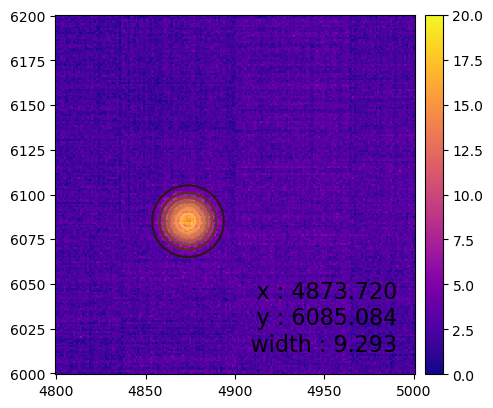

In [11]:
do_ghost((4900, 6100))

In [12]:
#show_hv_slices(imageF.getArray(), vpix=6300, hpix=2780, ccdname='random')

In [13]:
#     from lsst.afw import cameraGeom
#    tx = det.getTransform(cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
#    cam_x, cam_y = tx.getMapping().applyForward(np.vstack((x, y)))
#    return cam_x.ravel(), cam_y.ravel()

In [14]:
#from scipy import ndimage as ndi
#from skimage.feature import peak_local_max
#from skimage import data, img_as_float

In [15]:
#im = np.transpose(imageF.getArray())
#image_max = ndi.maximum_filter(im, size=20, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
#coordinates = peak_local_max(im, min_distance=20)

In [19]:
targets=[(3086.0695851985665, 6141.6332940262),
 (2007.7430569340174, 6715.706409792939),
 (4490.221395384779, 6215.331869698957),
 (758.7461429009786, 4442.687181148961),
 (4366.09747846224, 6936.8021368112095),
 (3784.2666178878435, 5404.647537298631),
 (2263.7486355867522, 4706.4505046093545),
 (2085.3205050106035, 5699.441839989659),
 (3877.3595555797465, 7095.835905368211),
 (4878.1086357677095, 6106.723442391736),
 (4319.551009616289, 5897.264332584953),
 (3225.708991736422, 5164.157448261213),
 (332.07017847975396, 5567.560178259461),
 (3559.2920184657432, 5505.498219798193),
 (1612.0980717434275, 5513.255964605852),
 (2806.7907721228557, 6312.30367979469),
 (3357.5906534666183, 5939.931929027076),
 (2255.990890779093, 4597.8420773021335)]

(1.6568338, 17.201157, 101.4572127889966, 90.53757983114822, 43.06583943981781)
[ 1.36817706e+00  1.42660051e+01  4.48587407e+03  6.19169765e+03
 -1.14063248e+01]
Center in camera bins coordinates: 4485.874071067806, 6191.6976501169, 14.266005105362684


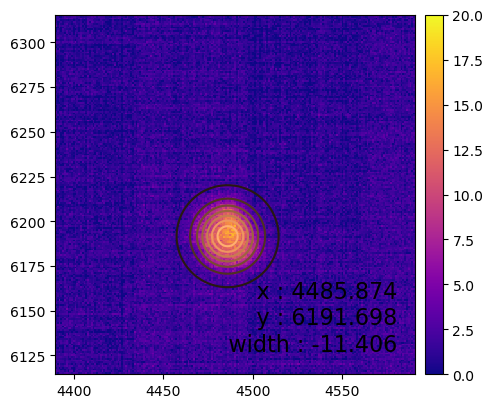

In [20]:
do_ghost(targets[2])

(1.6046649, 8.39868, 97.96979621863625, 93.02757026862193, 48.06900783941399)
[ 1.36504043e+00  5.33783232e+00  2.79457117e+03  6.29878965e+03
 -1.69898359e+01]
Center in camera bins coordinates: 2794.5711682780234, 6298.789648926835, 5.337832320415481


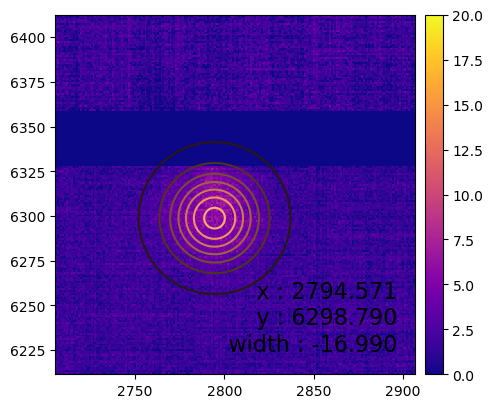

In [21]:
do_ghost(targets[-3])

(2.2614067, 85.96835, 100.19574112470879, 100.5114940973682, 56.163771945256215)
[ 2.10652892e+00  4.80648384e+00  1.62199213e+03  5.49675757e+03
 -1.43941837e+01]
Center in camera bins coordinates: 1621.9921303042233, 5496.757571147064, 4.806483837367629


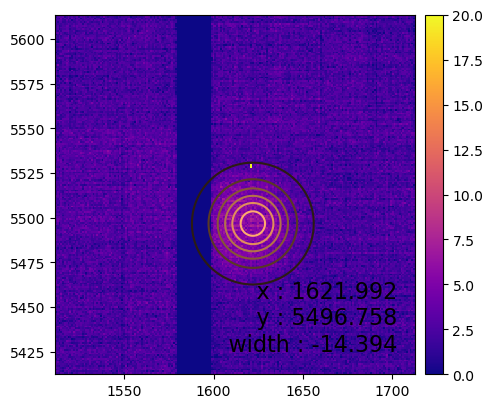

In [22]:
do_ghost(targets[-4])

(1.0009973, 19.150991, 102.20250189216851, 100.46428532259607, 45.77969034737694)
[ 7.04668542e-01  1.68987704e+01  3.57097700e+03  5.48978214e+03
 -1.06185563e+01]
Center in camera bins coordinates: 3570.9769956824216, 5489.782137362509, 16.89877041794353


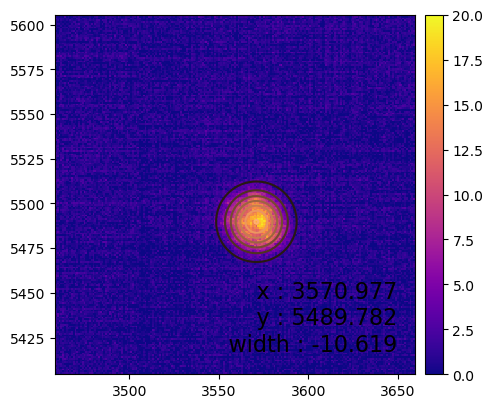

In [23]:
do_ghost(targets[-5])

(2.7280467, 8.328979, 98.75359325311479, 99.18772225094862, 51.83666597452342)
[2.44462267e+00 2.16959338e+00 3.32560275e+02 5.56955452e+03
 2.89981836e+01]
Center in camera bins coordinates: 332.5602753316279, 5569.554521358535, 2.16959338487184


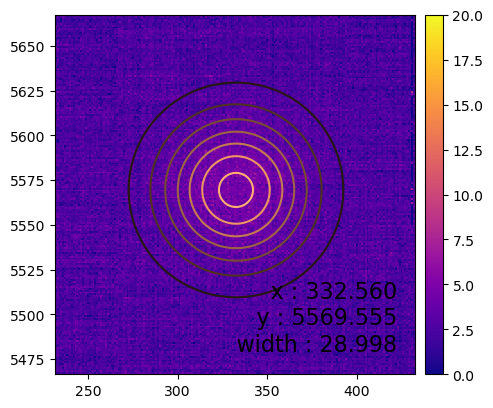

In [24]:
do_ghost(targets[-6])

(0.5466498, 12.154005, 110.60302715613989, 94.48202081344468, 44.671658225775154)
[3.57121072e-01 1.17777420e+01 3.21866837e+03 5.14525949e+03
 1.01721481e+01]
Center in camera bins coordinates: 3218.668368563574, 5145.259492878582, 11.777742011282285


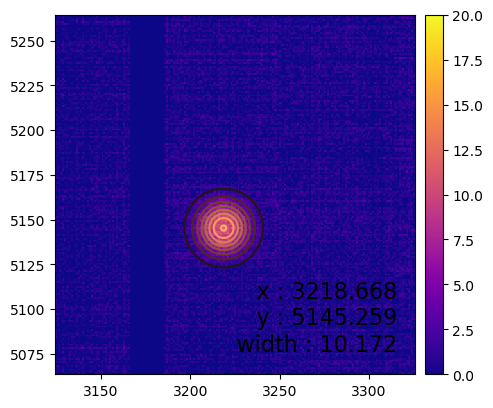

In [25]:
do_ghost(targets[-7])

(1.068802, 752.3324, 111.02401304391714, 112.86772600335155, 58.28797485885636)
[8.61003651e-01 1.30010656e+01 4.32480426e+03 5.88198854e+03
 1.01376601e+01]
Center in camera bins coordinates: 4324.804264676327, 5881.9885376942175, 13.001065623170133


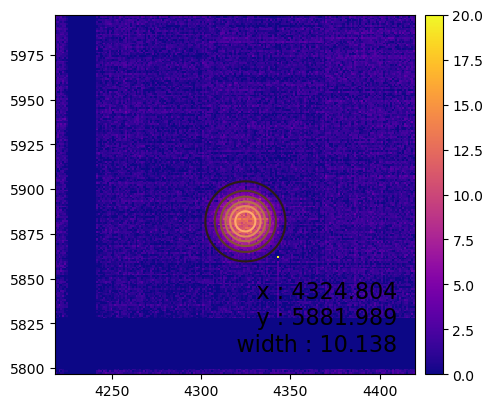

In [26]:
do_ghost(targets[-8])

(2.7070346, 84.62231, 103.95190452286536, 96.19299635182067, 55.2540406744327)
[ 2.50600304e+00  1.48281003e+01  4.87372142e+03  6.08508268e+03
 -9.33674532e+00]
Center in camera bins coordinates: 4873.721416181047, 6085.082684570621, 14.828100276300834


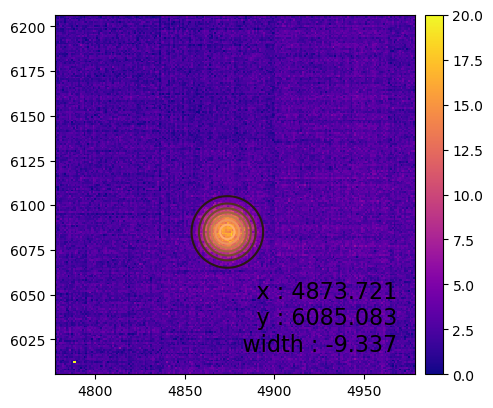

In [27]:
do_ghost(targets[-9])

(2.4232898, 13.603118, 95.20942473320764, 102.39757560017894, 51.07719112621024)
[2.18345466e+00 3.80364058e+00 3.87607740e+03 7.08321374e+03
 2.01355667e+01]
Center in camera bins coordinates: 3876.077402438628, 7083.213738305754, 3.803640576287002


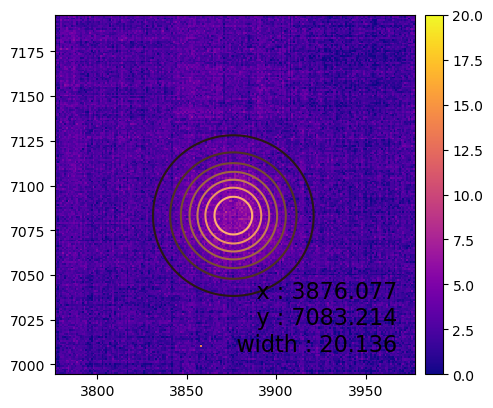

In [28]:
do_ghost(targets[-10])

(1.8384064, 8.485957, 95.4287605642609, 95.44340349377332, 51.78573738180315)
[ 1.63914926e+00  5.10668545e+00  2.08460215e+03  5.68865478e+03
 -1.58395799e+01]
Center in camera bins coordinates: 2084.6021516304704, 5688.65478268509, 5.106685448121125


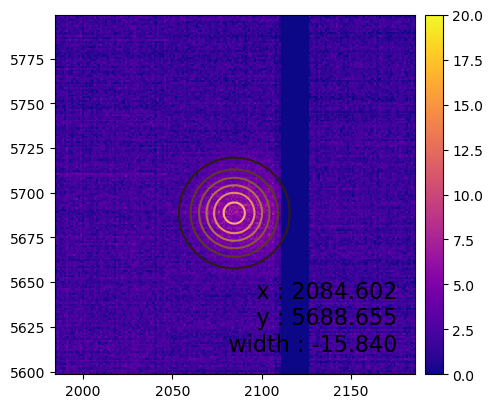

In [29]:
do_ghost(targets[-11])

(2.1667037, 19.182247, 85.0277776626106, 75.96134252631802, 45.16880104488646)
[6.92246330e-01 4.10249809e+00 2.20530087e+03 4.59867634e+03
 8.78334011e+01]
Center in camera bins coordinates: 2205.30086861831, 4598.676342786788, 4.102498091649222


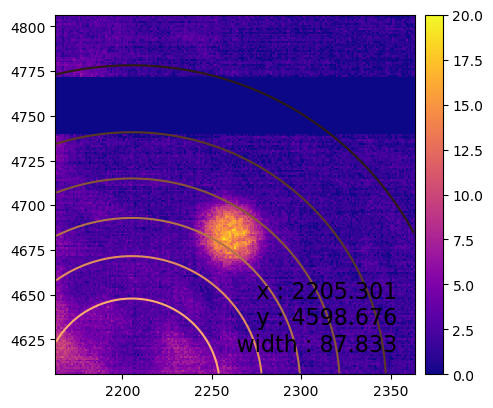

In [30]:
do_ghost(targets[-12])

In [31]:
spots_x = [one[0] for one in targets]
spots_y = [one[1] for one in targets]

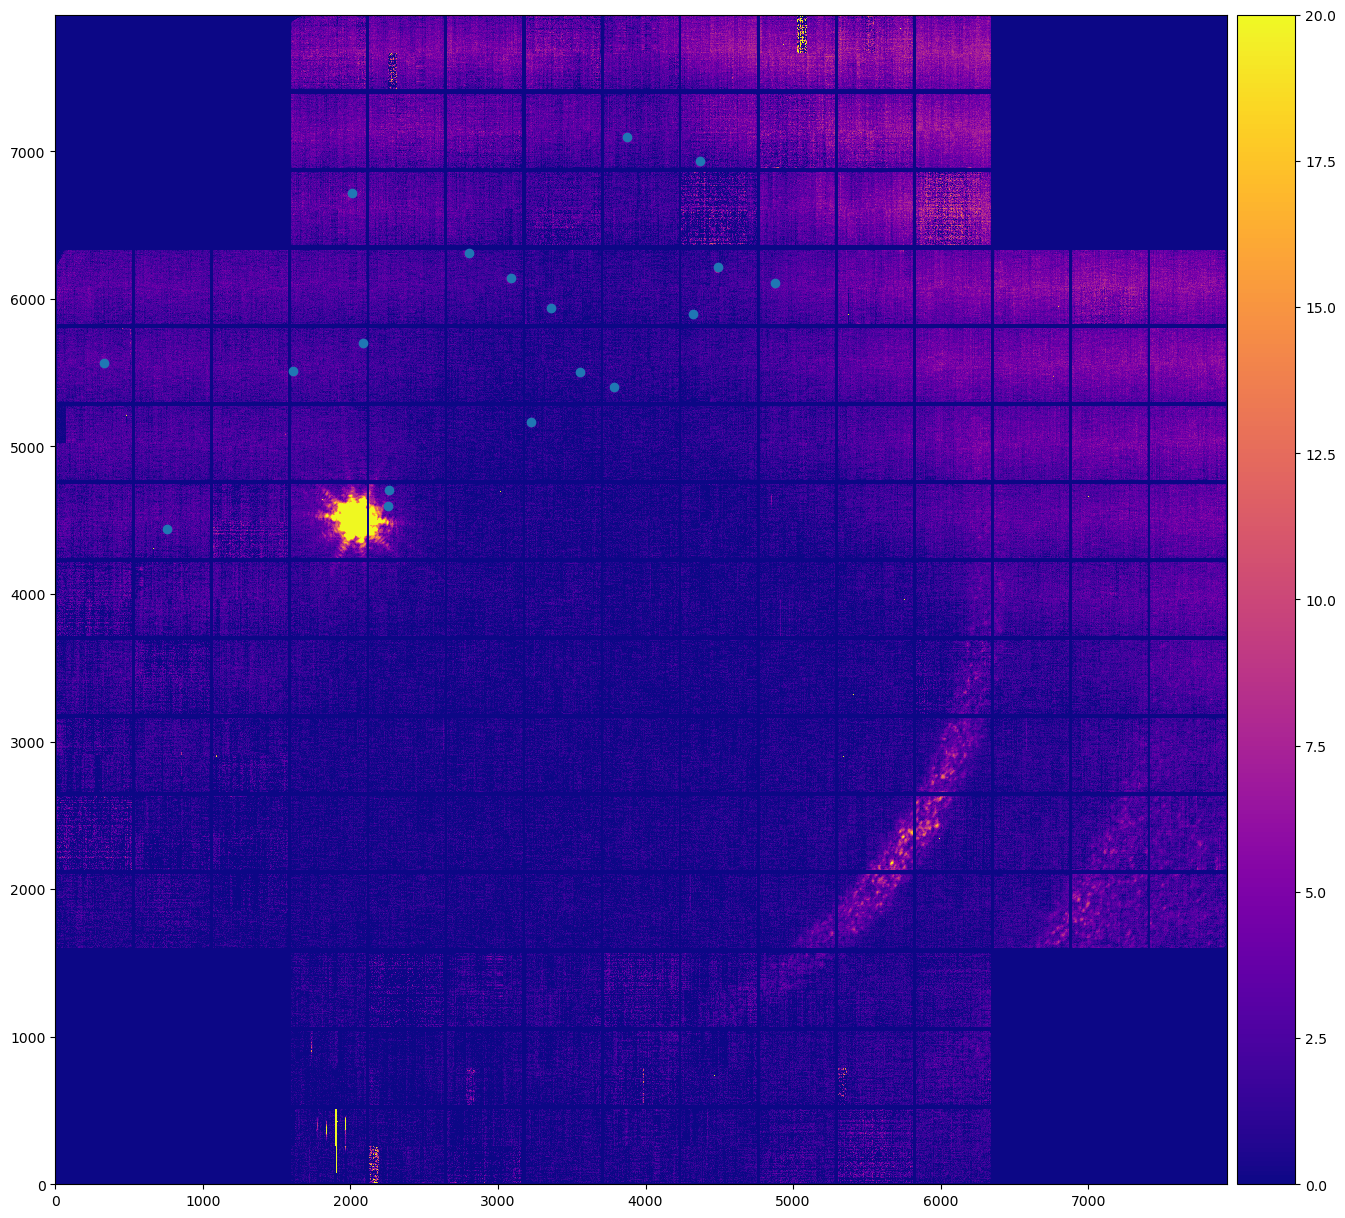

In [32]:
displayImageGhosts(imageF)
plt.scatter(spots_x, spots_y)

In [33]:
def plot_ghosts_map(targets_list):
    n_cols = 5
    n_rows=5
    fig, ax = plt.subplots(n_cols, n_rows, constrained_layout=True, figsize=(32, 32))
    axs = ax.ravel()
    for i, spot in enumerate(targets_list):
        ghost_stamp = make_stamp(*spot)
        fig.add_subplot(axs[i])
        plt.sca(axs[i])
        afw_display = afwDisplay.getDisplay(i) #afwDisplay.Display(i)
        #afw_display.scale('asinh', 'zscale')
        afw_display.scale('linear', min=0, max=20)
        afw_display.setImageColormap(cmap='plasma')
        afw_display.mtv(ghost_stamp)
        
        #do_ghost(spot)


In [75]:
def plot_ghosts_mosaic(targets_list):
    from lsst.afw.display.utils import Mosaic
    plt.rcParams["figure.figsize"] = [12, 12]
    # image list
    images = []
    for i, spot in enumerate(targets_list):
        images.append(make_stamp(*spot))
    # Mosaic
    m = Mosaic(gutter=30, background=0, mode='square')
    mosaic = m.makeMosaic(images)
    display = afwDisplay.Display(999)
    display.scale('linear', min=0, max=20)
    display.setImageColormap(cmap='plasma')
    display.mtv(mosaic)
    return m, display
        

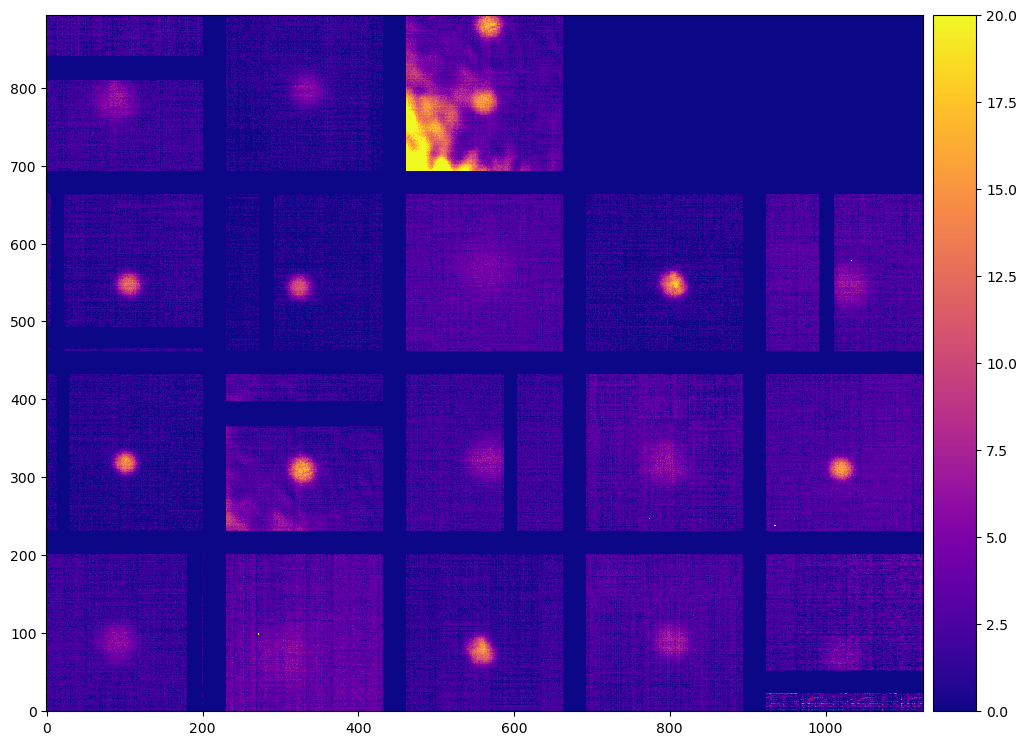

In [76]:
m, d = plot_ghosts_mosaic(targets)
